# Testing - scentS grid w/ noise - 6

Threshold - Distance, deaths, and reward collection in an open grid

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

from explorationlib import score
from explorationlib.score import search_efficiency
from explorationlib.score import first_reward
from explorationlib.score import average_reward
from explorationlib.score import total_reward
from explorationlib.score import num_death

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Shared params, env, and agents

In [4]:
num_steps = 200
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 # 5000-50000
target_boundary = (100, 100)

# Env
env = gym.ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = gym.uniform_targets(num_targets, target_boundary, prng=prng)
values = gym.constant_values(targets, 1)

# Scents
coord, scent = gym.create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)


<IPython.core.display.Javascript object>

## Explore threshold
Fix noise, and threshold

In [6]:
# Experiment settings
num_experiments = 10
max_steps = 10
accumulate_sigma = 1.0
drift_rate = 1.0

thresholds = [0.1, 1.0, 2.0, 3.0, 4.0]
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = list(range(5))

# -
results = []
for i, threshold in zip(names, thresholds):
    accum = agent.AccumulatorGradientCardinal(
        min_length=min_length, 
        max_steps=max_steps, 
        drift_rate=drift_rate, 
        threshold=threshold,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_4: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


<IPython.core.display.Javascript object>

## Example 

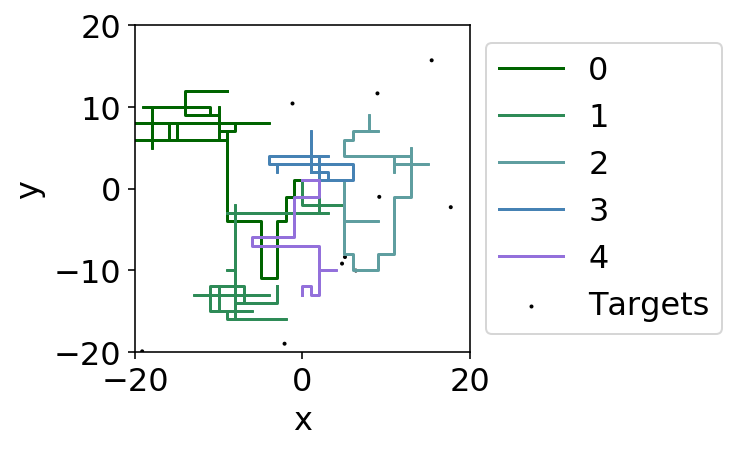

<IPython.core.display.Javascript object>

In [7]:
plot_boundary = (20, 20)
num_experiment = 0
ax = None
for i, result, color in zip(names, results, colors):
    ax = plot_position2d(
        select_exp(result, num_experiment),
        boundary=plot_boundary,
        label=i,
        color=color,
        alpha=1,
        ax=ax,
    )
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Total distance

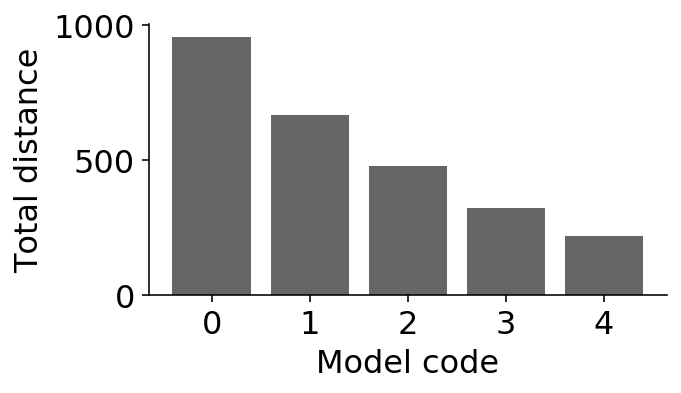

<IPython.core.display.Javascript object>

In [16]:
# Results
scores = []
for i, result, color in zip(names, results, colors):
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))

# Plot means
names = list(range(5))
fig = plt.figure(figsize=(5, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

## Deaths

num_death: 100%|██████████| 10/10 [00:00<00:00, 7693.15it/s]


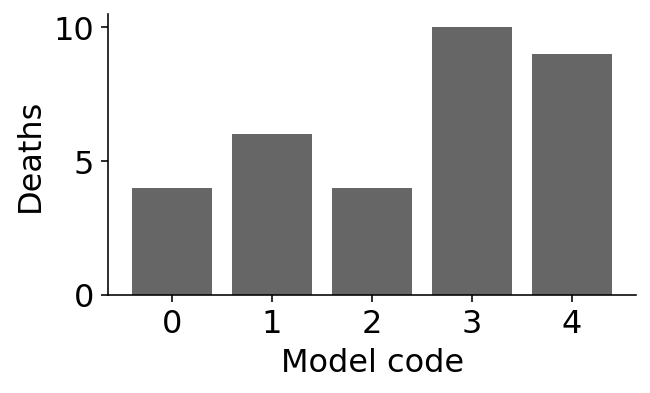

<IPython.core.display.Javascript object>

In [17]:
scores = []
for i, result, color in zip(names, results, colors):
    scores.append(num_death(result))   

# Plot means
names = list(range(5))
fig = plt.figure(figsize=(5, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

## Avg reward

total_reward: 100%|██████████| 10/10 [00:00<00:00, 7319.90it/s]


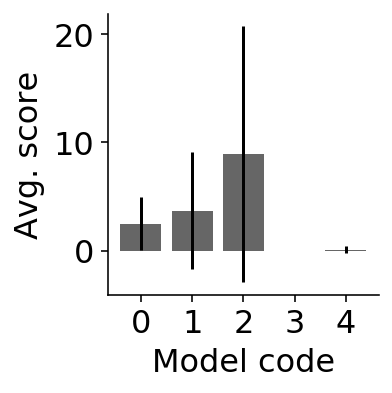

<IPython.core.display.Javascript object>

In [18]:
# Results
scores = []
for i, result, color in zip(names, results, colors):    
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

## Best exp

total_reward: 100%|██████████| 10/10 [00:00<00:00, 6605.20it/s]


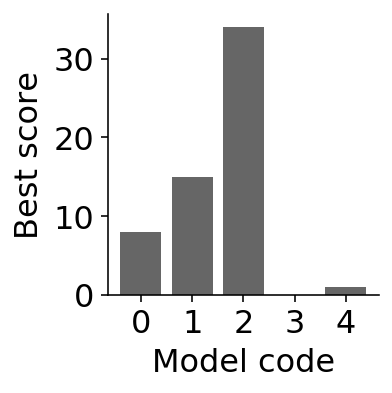

<IPython.core.display.Javascript object>

In [19]:
# Results
scores = []
for i, result, color in zip(names, results, colors):    
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in zip(scores):
    m.append(np.max(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

## Reward histogram

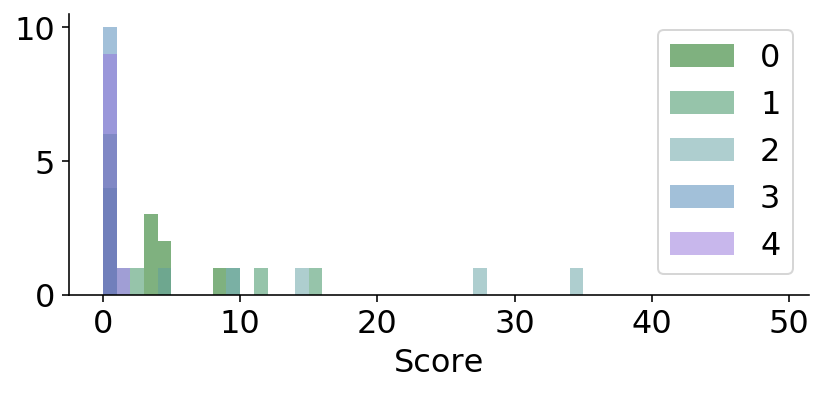

<IPython.core.display.Javascript object>

In [20]:
# Dists
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(0,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()